In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
import json
pd.set_option("display.max_rows",500) 
pd.set_option("display.max_columns",500) 
pd.set_option('display.max_colwidth', None)
import requests
import json
import time
import requests
import json
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import requests_cache
from retry_requests import retry
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from xgboost import plot_importance

!!! Güneş Enerjisi Verilerinin Çekilmesi (EPİAŞ)

In [4]:
url = "https://giris.epias.com.tr/cas/v1/tickets"
payload = {
    'username': '20360859065@ogr.btu.edu.tr',
    'password': 'Kanguru.123'
}
headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'Accept': 'text/plain'
}
response = requests.post(url, data=payload, headers=headers)

if response.status_code == 201:
    tgt = response.text
    print("TGT:", tgt)
else:
    print("TGT alınırken hata oluştu:", response.status_code)
    print("Yanıt:", response.text)

TGT: TGT-21840584--6SESjG47Tkko8hYkV28q2bzEqtq4Y0cBOOnUbKN30cO-hMFlT1v1NN4OD7Mb9Em5Kk-cas-9959f8d46-g4ncl


In [ ]:
url = "https://seffaflik.epias.com.tr/electricity-service/v1/renewables/data/licensed-realtime-generation"

headers = {
    "Accept-Language": "en",
    "Accept": "application/json",
    "Content-Type": "application/json",
    "TGT": tgt
}
start_date = datetime(2022, 1, 1)
end_date = datetime(2025, 3, 2)

all_data = []

current_start = start_date
while current_start < end_date:
    current_end = current_start + relativedelta(months=1)

    payload = {
        "startDate": current_start.isoformat() + "+03:00",
        "endDate": current_end.isoformat() + "+03:00"
    }

    response = requests.post(url, headers=headers, data=json.dumps(payload))
    print(f"İstek: {payload['startDate']} - {payload['endDate']}")

    if response.status_code == 200:
        data = response.json()
        all_data.append(data)
        print("Başarılı")
    else:
        print("Hata:", response.status_code)
        print(response.text)

    current_start = current_end

df_gunes=pd.DataFrame(all_data[0]["items"])
df_gunes=df_gunes[["date","gunes"]]

In [ ]:
all_items = []
for entry in all_data:
    items = entry.get("items", [])
    all_items.extend(items)

df_gunes = pd.DataFrame(all_items)
df_gunes=df_gunes[["date","gunes"]]
df_gunes.to_csv("güneş_enerji_verileri/gunesenerji_uretim.csv", index=False)

!!! Kurulu Güç Verilerinin Çekilmesi (EPİAŞ)

In [6]:
url = "https://seffaflik.epias.com.tr/electricity-service/v1/renewables/data/renewables-participant"

headers = {
    "Accept-Language": "en",
    "Accept": "application/json",
    "Content-Type": "application/json",
    "TGT": tgt
}

years = [2022, 2023, 2024, 2025]
all_data = []

for year in years:
    payload = {"year": str(year)}
    response = requests.post(url, headers=headers, data=json.dumps(payload))

    print(f"🔄 {year} verisi isteniyor...")

    if response.status_code == 200:
        data = response.json()
        all_data.append(data)
        print(f"{year} verisi başarıyla çekildi.")
    else:
        print(f"{year} verisi çekilemedi. Kod: {response.status_code}")
        print("Hata mesajı:", response.text)

🔄 2022 verisi isteniyor...
2022 verisi başarıyla çekildi.
🔄 2023 verisi isteniyor...
2023 verisi başarıyla çekildi.
🔄 2024 verisi isteniyor...
2024 verisi başarıyla çekildi.
🔄 2025 verisi isteniyor...
2025 verisi başarıyla çekildi.


In [7]:
all_items = []
for entry in all_data:
    items = entry.get("items", [])
    all_items.extend(items)

df_kuruluguc = pd.DataFrame(all_items)
df_kuruluguc=df_kuruluguc[df_kuruluguc["facilityType"]=="Fotovoltaik"]
df_kuruluguc=df_kuruluguc[["orgName","facilityName","installedPower","entryDate"]]
df_kuruluguc.drop_duplicates(inplace=True)
df_kuruluguc = df_kuruluguc.loc[df_kuruluguc.groupby(["orgName", "facilityName"])["installedPower"].idxmax()].reset_index(drop=True)
df_kuruluguc_il= pd.read_excel("güneş_enerji_verileri/il_kuruluguc.xlsx")
df_kuruluguc=pd.merge(df_kuruluguc,df_kuruluguc_il,on=["facilityName"],how="left")

!!! Hava Durumu Verilerinin Çekilmesi (OpenMeteo)

In [8]:
df_coordinates=pd.read_csv("güneş_enerji_verileri\Coordinates.csv")
df_coordinates.head()

,Province,latitude,longitude
0,Adana,37.100000,35.321333
1,Adıyaman,37.764751,38.278561
2,Afyonkarahisar,38.750714,30.556692
3,Ağrı,39.626922,43.021596
4,Aksaray,38.368690,34.036980


In [ ]:
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = Client(session=retry_session)

start_date = datetime(2022, 1, 1)
end_date = datetime(2025, 3, 2)
step = timedelta(days=90)

all_city_data = []

for index, row in df_coordinates.iterrows():
    city_name = row["Province"]
    lat = row["latitude"]
    lon = row["longitude"]
    
    current_start = start_date

    while current_start < end_date:
        current_end = min(current_start + step, end_date)

        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": current_start.strftime("%Y-%m-%d"),
            "end_date": current_end.strftime("%Y-%m-%d"),
            "hourly": [
                "temperature_2m",
                "cloud_cover",
                "is_day",
                "sunshine_duration",
                "rain",
                "snowfall",
                "global_tilted_irradiance_instant"
            ]
        }

        success = False
        retry_count = 0
        max_retries = 5

        while not success and retry_count < max_retries:
            try:
                responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
                response = responses[0]
                hourly = response.Hourly()

                df = pd.DataFrame({
                    "date": pd.date_range(
                        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                        freq=pd.Timedelta(seconds=hourly.Interval()),
                        inclusive="left"
                    ),
                    "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
                    "cloud_cover": hourly.Variables(1).ValuesAsNumpy(),
                    "is_day": hourly.Variables(2).ValuesAsNumpy(),
                    "sunshine_duration": hourly.Variables(3).ValuesAsNumpy(),
                    "rain": hourly.Variables(4).ValuesAsNumpy(),
                    "snowfall": hourly.Variables(5).ValuesAsNumpy(),
                    "global_tilted_irradiance_instant": hourly.Variables(6).ValuesAsNumpy(),
                })
                df["city"] = city_name
                df["latitude"] = lat
                df["longitude"] = lon

                all_city_data.append(df)
                print(f"{city_name}: {current_start.date()} - {current_end.date()} verisi alındı.")
                success = True
            except Exception as e:
                retry_count += 1
                print(f"{city_name}: {current_start.date()} - {current_end.date()} verisi alınamadı. {retry_count}. deneme. Hata: {e}")
                time.sleep(60)

        current_start = current_end
        time.sleep(1)

combined_df = pd.concat(all_city_data, ignore_index=True)

Adana: 2022-01-01 - 2022-04-01 verisi alındı.
Adana: 2022-04-01 - 2022-06-30 verisi alındı.
Adana: 2022-06-30 - 2022-09-28 verisi alındı.
Adana: 2022-09-28 - 2022-12-27 verisi alındı.
Adana: 2022-12-27 - 2023-03-27 verisi alındı.
Adana: 2023-03-27 - 2023-06-25 verisi alındı.
Adana: 2023-06-25 - 2023-09-23 verisi alındı.
Adana: 2023-09-23 - 2023-12-22 verisi alındı.
Adana: 2023-12-22 - 2024-03-21 verisi alındı.
Adana: 2024-03-21 - 2024-06-19 verisi alındı.
Adana: 2024-06-19 - 2024-09-17 verisi alındı.
Adana: 2024-09-17 - 2024-12-16 verisi alındı.
Adana: 2024-12-16 - 2025-03-02 verisi alındı.
Adıyaman: 2022-01-01 - 2022-04-01 verisi alındı.
Adıyaman: 2022-04-01 - 2022-06-30 verisi alındı.
Adıyaman: 2022-06-30 - 2022-09-28 verisi alındı.
Adıyaman: 2022-09-28 - 2022-12-27 verisi alındı.
Adıyaman: 2022-12-27 - 2023-03-27 verisi alındı.
Adıyaman: 2023-03-27 - 2023-06-25 verisi alındı.
Adıyaman: 2023-06-25 - 2023-09-23 verisi alındı.
Adıyaman: 2023-09-23 - 2023-12-22 verisi alındı.
Adıyaman: 

In [ ]:
combined_df["date"] = combined_df["date"].dt.tz_convert("Europe/Istanbul")
combined_df.to_csv("güneş_enerji_verileri/weather.csv", index=False)

!!! Hava Durumu ve Kurulu Güç Verilerinin Birleştirilmesi

In [9]:
weather=pd.read_csv("güneş_enerji_verileri/weather.csv")
weather.head()

,date,temperature_2m,cloud_cover,is_day,sunshine_duration,rain,snowfall,global_tilted_irradiance_instant,city,latitude,longitude
0,2022-01-01 03:00:00+03:00,9.996500,0.0,0.0,0.0,0.0,0.0,0.0,Adana,37.1,35.321333
1,2022-01-01 04:00:00+03:00,9.096499,21.0,0.0,0.0,0.0,0.0,0.0,Adana,37.1,35.321333
2,2022-01-01 05:00:00+03:00,9.196500,58.0,0.0,0.0,0.0,0.0,0.0,Adana,37.1,35.321333
3,2022-01-01 06:00:00+03:00,8.996500,14.0,0.0,0.0,0.0,0.0,0.0,Adana,37.1,35.321333
4,2022-01-01 07:00:00+03:00,8.446500,18.0,0.0,0.0,0.0,0.0,0.0,Adana,37.1,35.321333


In [10]:
df_kuruluguc.head()

,orgName,facilityName,installedPower,entryDate,city
0,AAB ENERJİ ÜRETİM TARIMSAL ÜRÜNLER GIDA İNŞAAT SANAYİ TİCARET ANONİM ŞİRKETİ,GİTAŞ - 1 GES,8.00,2020-12-31T00:00:00+03:00,Konya
1,AFTA ENERJİ ÜRETİM SANAYİ VE TİCARET ANONİM ŞİRKETİ,AFTA GES,9.80,2019-09-20T00:00:00+03:00,Konya
2,ANTGES ENERJİ ÜRETİM ANONİM ŞİRKETİ,KÜÇÜKKÖY GES,18.61,2020-10-28T00:00:00+03:00,Antalya
3,BALTECH ENERJİ ÜRETİM PAZARLAMA SANAYİ VE TİCARET ANONİM ŞİRKETİ,TAŞKESİĞİ GES,10.39,2020-12-18T00:00:00+03:00,Antalya
4,BOLAYIR ENERJİ SANAYİ VE TİCARET ANONİM ŞİRKETİ.,SERRA GES,5.60,2020-07-10T00:00:00+03:00,Antalya


In [11]:
df_kuruluguc["entryDate"] = pd.to_datetime(df_kuruluguc["entryDate"])
df_kuruluguc["entryDate"]=df_kuruluguc["entryDate"].dt.date
expanded_rows = []
for _, row in df_kuruluguc.iterrows():
    date_range = pd.date_range(start="2022-01-01", end="2025-03-02", freq="D")
    for date in date_range:
        new_row = row.copy()
        new_row["entryDate"] = date
        expanded_rows.append(new_row)

df_kuruluguc_expanded = pd.DataFrame(expanded_rows)

In [12]:
df_kuruluguc_expanded=df_kuruluguc_expanded[(df_kuruluguc_expanded["entryDate"] >= pd.to_datetime("2022-01-01")) & (df_kuruluguc_expanded["entryDate"] <= pd.to_datetime("2025-03-01"))]
df_kuruluguc_expanded["entryDate"]=df_kuruluguc_expanded["entryDate"].dt.date
df_kuruluguc_expanded2 = df_kuruluguc_expanded.groupby(["entryDate", "city"], as_index=False)["installedPower"].sum()
df_kuruluguc_expanded2.head()

,entryDate,city,installedPower
0,2022-01-01,Adıyaman,9.99
1,2022-01-01,Antalya,58.00
2,2022-01-01,Bitlis,16.00
3,2022-01-01,Burdur,26.15
4,2022-01-01,Denizli,15.00


In [13]:
weather['date'] = pd.to_datetime(weather['date'])
weather['Year'] = weather['date'].dt.year
weather['Month'] = weather['date'].dt.month
weather['Day'] = weather['date'].dt.day

df_kuruluguc_expanded2['entryDate'] = pd.to_datetime(df_kuruluguc_expanded2['entryDate'])
df_kuruluguc_expanded2['Year'] = df_kuruluguc_expanded2['entryDate'].dt.year
df_kuruluguc_expanded2['Month'] = df_kuruluguc_expanded2['entryDate'].dt.month
df_kuruluguc_expanded2['Day'] = df_kuruluguc_expanded2['entryDate'].dt.day

weather = weather.merge(df_kuruluguc_expanded2[['Year', 'Month', 'Day', 'installedPower', 'city']], left_on=['Year', 'Month', 'Day','city'], right_on=['Year', 'Month', 'Day','city'], how='left').drop(columns=['Day',"Year","Month","latitude","longitude"])
weather=weather[weather["installedPower"].notnull()]

In [14]:
weather["panel_temprature"]=weather["temperature_2m"]+(25*weather["global_tilted_irradiance_instant"]/800)
#Tp = To + (NOTC-20C)* It / 800

In [15]:
weather["productivity_per"]=weather["panel_temprature"].apply(lambda x: 1-((x-25)*0.004) if x>=25 else 1)
weather["productivity"]=weather["installedPower"]*weather["productivity_per"]

In [16]:
weather["non_cloud"] = 100 - weather["cloud_cover"]
weather["sun"] = weather["productivity"]*weather["non_cloud"]*weather["sunshine_duration"]*weather["is_day"]/weather["productivity"].sum()/3600

In [ ]:
!!! Verinin Modele Hazırlanması

In [17]:
df=pd.read_csv("güneş_enerji_verileri/gunesenerji_uretim.csv")
df=df[["date","gunes"]]
df["date"]=pd.to_datetime(df["date"])
df.drop_duplicates(inplace=True)
df["gunes"] = df["gunes"].fillna(method="ffill")
df['gunes_1g'] = df['gunes'].shift(24)
df.dropna(inplace=True)
start_date = '2022-01-01'
end_date = '2025-03-01'
mask = (df['date'] >= start_date) & (df['date'] <= end_date)
df = df[mask]
df.head()

,date,gunes,gunes_1g
24,2022-01-02 00:00:00+03:00,0.0,0.0
25,2022-01-02 01:00:00+03:00,0.0,0.0
26,2022-01-02 02:00:00+03:00,0.0,0.0
27,2022-01-02 03:00:00+03:00,0.0,0.0
28,2022-01-02 04:00:00+03:00,0.0,0.0


In [18]:
df["hour"]=df["date"].dt.hour #onehot encoding!!!
df["dayofweek"]=df["date"].dt.dayofweek #onehot encoding!!!
df["month"]=df["date"].dt.month #onehot encoding!!!

In [19]:
il_sum = weather.groupby('date')['sun'].sum().reset_index()
il_sum["date"]=pd.to_datetime(il_sum['date'])
df = pd.merge(df, il_sum, on='date', how='left')
df.dropna(inplace=True)

In [20]:
def season(month):
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    elif month in [9, 10, 11]:
        return "autumn"

df["season"]=df["date"].dt.month.apply(season) #onehot encoding!!!

In [21]:
df=pd.get_dummies(df, columns=["hour","dayofweek","season","month"])
df.head()

,date,gunes,gunes_1g,sun,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_autumn,season_spring,season_summer,season_winter,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2022-01-02 00:00:00+03:00,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2022-01-02 01:00:00+03:00,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,2022-01-02 02:00:00+03:00,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,2022-01-02 03:00:00+03:00,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,2022-01-02 04:00:00+03:00,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [22]:
train = df[(df["date"] >= "2022-01-01") & (df["date"] < "2024-07-01")]
valid = df[(df["date"] >= "2024-07-01") & (df["date"] < "2025-01-01")]
test = df[df["date"] >= "2025-01-01"]
X_train, y_train = train.drop(columns=["date", "gunes"]), train["gunes"]
X_valid, y_valid = valid.drop(columns=["date", "gunes"]), valid["gunes"]
X_test,  y_test  = test.drop(columns=["date", "gunes"]),  test["gunes"]

!!! Model Eğitimi

In [23]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=1.0,
    gamma=0.1,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    reg_alpha=0.1,
    reg_lambda=1.5,
    subsample=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    early_stopping_rounds=20,
    verbose=True
)

predictions = model.predict(X_test)
predictions = np.where(predictions < 0, 0, predictions)

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MAE: {mae:.4f}, R²: {r2:.4f}')

[0]	validation_0-rmse:565.89043	validation_1-rmse:633.91004
[1]	validation_0-rmse:513.34709	validation_1-rmse:573.03916
[2]	validation_0-rmse:466.40048	validation_1-rmse:518.46388
[3]	validation_0-rmse:424.41879	validation_1-rmse:470.39806
[4]	validation_0-rmse:386.94657	validation_1-rmse:427.35555
[5]	validation_0-rmse:353.66121	validation_1-rmse:388.41219
[6]	validation_0-rmse:324.28023	validation_1-rmse:353.70641
[7]	validation_0-rmse:298.17362	validation_1-rmse:323.04305
[8]	validation_0-rmse:275.12903	validation_1-rmse:296.31982


d:\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:254.91216	validation_1-rmse:273.12779
[10]	validation_0-rmse:237.06071	validation_1-rmse:252.28281
[11]	validation_0-rmse:221.47871	validation_1-rmse:233.93360
[12]	validation_0-rmse:207.85990	validation_1-rmse:217.70352
[13]	validation_0-rmse:196.05020	validation_1-rmse:204.10646
[14]	validation_0-rmse:185.87121	validation_1-rmse:191.88495
[15]	validation_0-rmse:177.14740	validation_1-rmse:181.50373
[16]	validation_0-rmse:169.70376	validation_1-rmse:172.69027
[17]	validation_0-rmse:163.24155	validation_1-rmse:165.11917
[18]	validation_0-rmse:157.69814	validation_1-rmse:158.67541
[19]	validation_0-rmse:153.03023	validation_1-rmse:153.48280
[20]	validation_0-rmse:149.06180	validation_1-rmse:149.06214
[21]	validation_0-rmse:145.70164	validation_1-rmse:145.40061
[22]	validation_0-rmse:142.71152	validation_1-rmse:142.12889
[23]	validation_0-rmse:140.24148	validation_1-rmse:139.39572
[24]	validation_0-rmse:138.21462	validation_1-rmse:137.20966
[25]	validation_0-rmse:13

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

predictions = model.predict(X_test)
predictions = np.where(predictions < 0, 0, predictions)

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MAE: {mae:.4f}, R²: {r2:.4f}')

MAE: 75.3074, R²: 0.8809


In [ ]:
param_grid = {
    'n_estimators': [200, 300],             # Daha fazla ağaç — öğrenme kapasitesi artar
    'max_depth': [6, 8],                    # Daha derin ağaçlar — karmaşık yapılar öğrenilir
    'learning_rate': [0.03, 0.05, 0.07],    # Daha küçük — daha stabil ve ince öğrenme
    'subsample': [0.9, 1.0],                # Tam veriyle öğrenme şansı
    'colsample_bytree': [0.9, 1.0],         # Tüm özellikleri kullanmak faydalı olabilir
    'gamma': [0],                           # Sıfır — dallanmayı engelleyen cezayı kaldır
    'reg_alpha': [0, 0.05],                 # L1 cezasını azalt
    'reg_lambda': [0.5, 1.0]                # L2 cezasını da azalt
}


# Temel model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# GridSearchCV: 5 katlı çapraz doğrulama, erken durdurmayı desteklemek için fit_params ile
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Hata minimize edilecek
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 1. GridSearch ile en iyi parametreyi bul
grid_search.fit(X_train, y_train)
print(f"Best params: {grid_search.best_params_}")

# 2. En iyi parametrelerle modeli erken durdurma kullanarak eğit
best_params = grid_search.best_params_
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=50,
    verbose=True
)

# Tahmin
predictions = model.predict(X_test)
predictions = np.where(predictions < 0, 0, predictions)

# Performans ölçümleri
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}')


Fitting 5 folds for each of 192 candidates, totalling 960 fits


KeyboardInterrupt: 

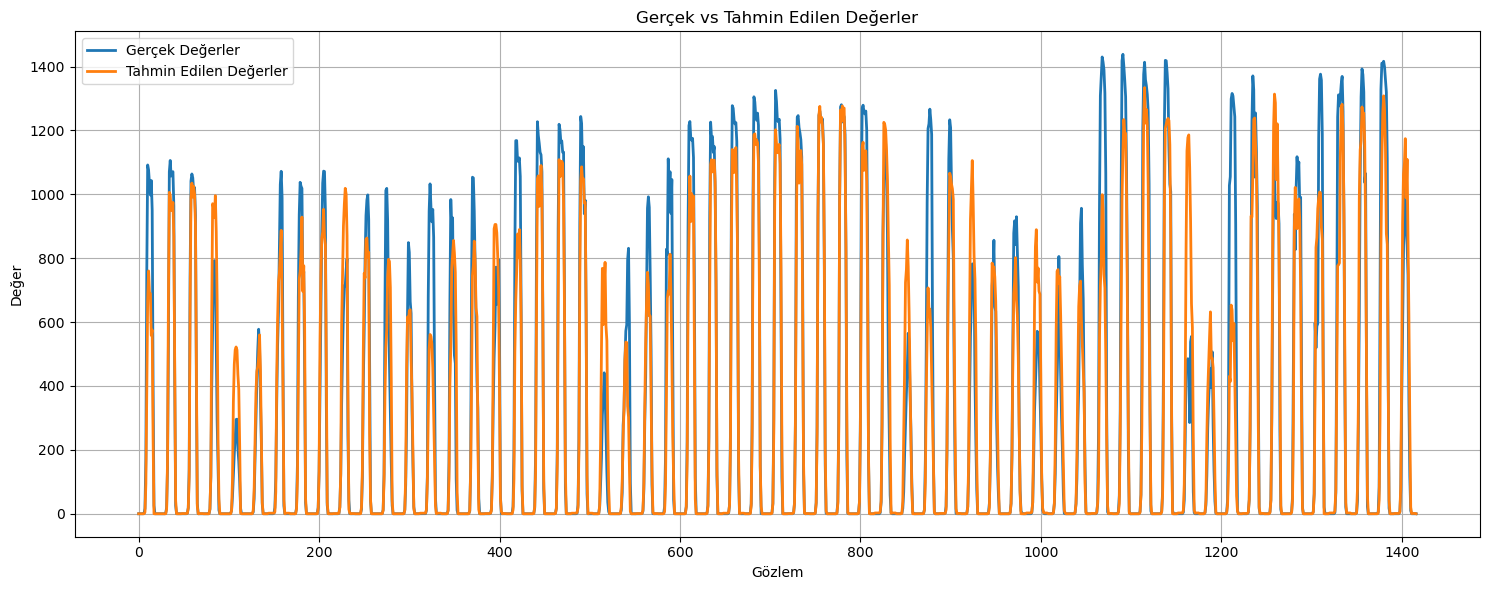

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Gerçek Değerler', linewidth=2)
plt.plot(predictions, label='Tahmin Edilen Değerler', linewidth=2)
plt.title('Gerçek vs Tahmin Edilen Değerler')
plt.xlabel('Gözlem')
plt.ylabel('Değer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

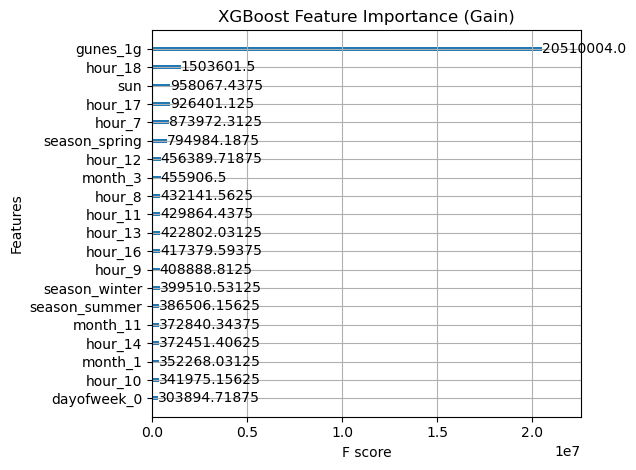

In [25]:
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='gain', max_num_features=20)
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()